In [1]:
# 1. Import Libraries
# ===========================
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import os
import warnings


In [2]:
# 2. Load and Preprocess Data
# ===========================
# The "../" tells the code to go up one level from the 'notebooks' folder
# to the main project folder, and then go down into the 'data' folder.
file_path = "../data/indian_store_data.csv"

# Load your dataset
df = pd.read_csv(file_path)

# --- IMPORTANT ---
# Verify these column names match your file exactly after running df.info() below.
DATE_COLUMN = 'Order Date'
SALES_COLUMN = 'Sales'
# ---

# Convert date column to datetime format
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Aggregate total daily sales across all stores
daily_sales = df.groupby(DATE_COLUMN)[SALES_COLUMN].sum().reset_index()
daily_sales = daily_sales.sort_values(by=DATE_COLUMN)

print("\n--- Data Preprocessing Complete ---")
print("Aggregated Daily Sales Data Head:")
print(daily_sales.head())
df.info()


FileNotFoundError: [Errno 2] No such file or directory: '../data/indian_store_data.csv'

In [3]:
import os
print(os.getcwd())

C:\Users\jayan\Desktop\bigbasket-flipkart-forecasting\notebooks


In [4]:
import os
print(os.listdir('../data'))

['indian_store_data.csv.csv']


In [5]:
# 2. Load and Preprocess Data
# ===========================
# Using the exact, corrected filename
file_path = "../data/indian_store_data.csv.csv"

# Load your dataset
df = pd.read_csv(file_path)

# --- IMPORTANT ---
# Verify these column names match your file exactly after running df.info() below.
DATE_COLUMN = 'Order Date'
SALES_COLUMN = 'Sales'
# ---

# Convert date column to datetime format
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Aggregate total daily sales across all stores
daily_sales = df.groupby(DATE_COLUMN)[SALES_COLUMN].sum().reset_index()
daily_sales = daily_sales.sort_values(by=DATE_COLUMN)

print("\n--- Data Preprocessing Complete ---")
print("File loaded successfully!")
df.info()



--- Data Preprocessing Complete ---
File loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Customer ID        100000 non-null  object        
 1   Customer Name      100000 non-null  object        
 2   Last Name          100000 non-null  object        
 3   Date of Birth      100000 non-null  object        
 4   Sales              100000 non-null  float64       
 5   Year               100000 non-null  int64         
 6   Outlet Type        100000 non-null  object        
 7   City Type          100000 non-null  object        
 8   Category of Goods  100000 non-null  object        
 9   Region             100000 non-null  object        
 10  Country            100000 non-null  object        
 11  Segment            100000 non-null  object        
 12  Sales Date         100000 non-null  ob

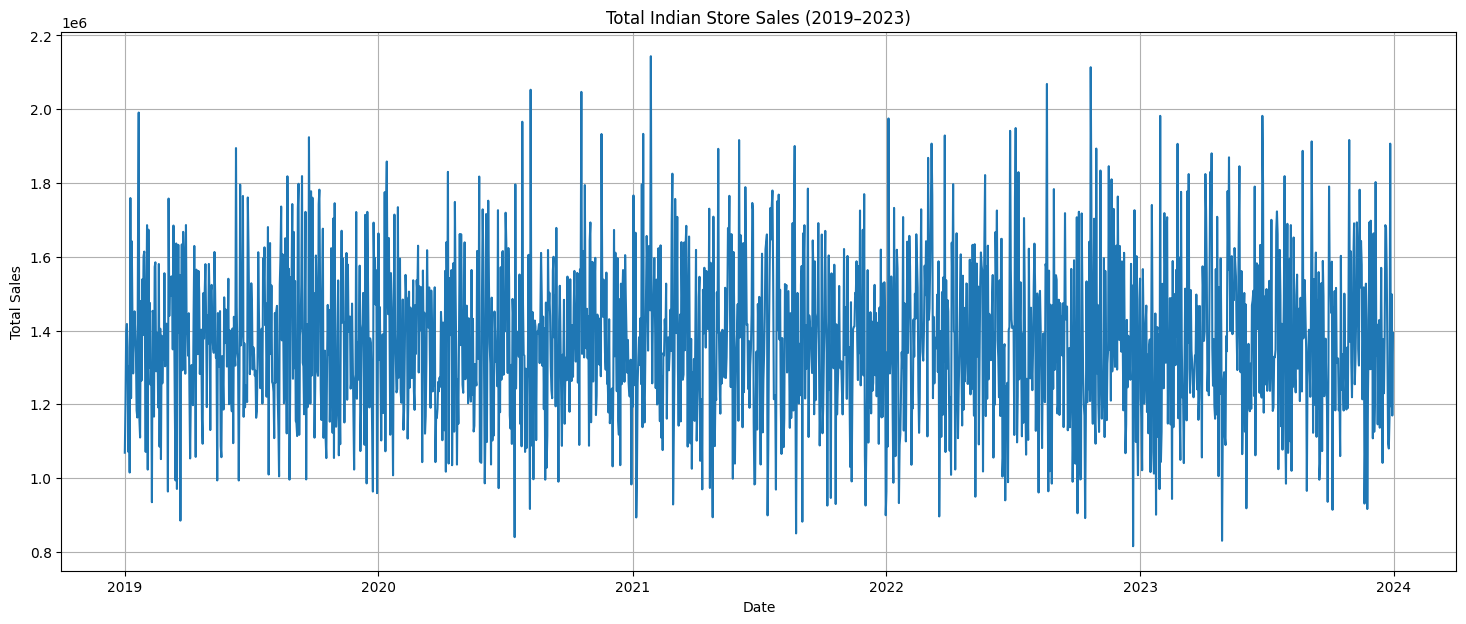


--- Plotting Seasonal Decomposition ---


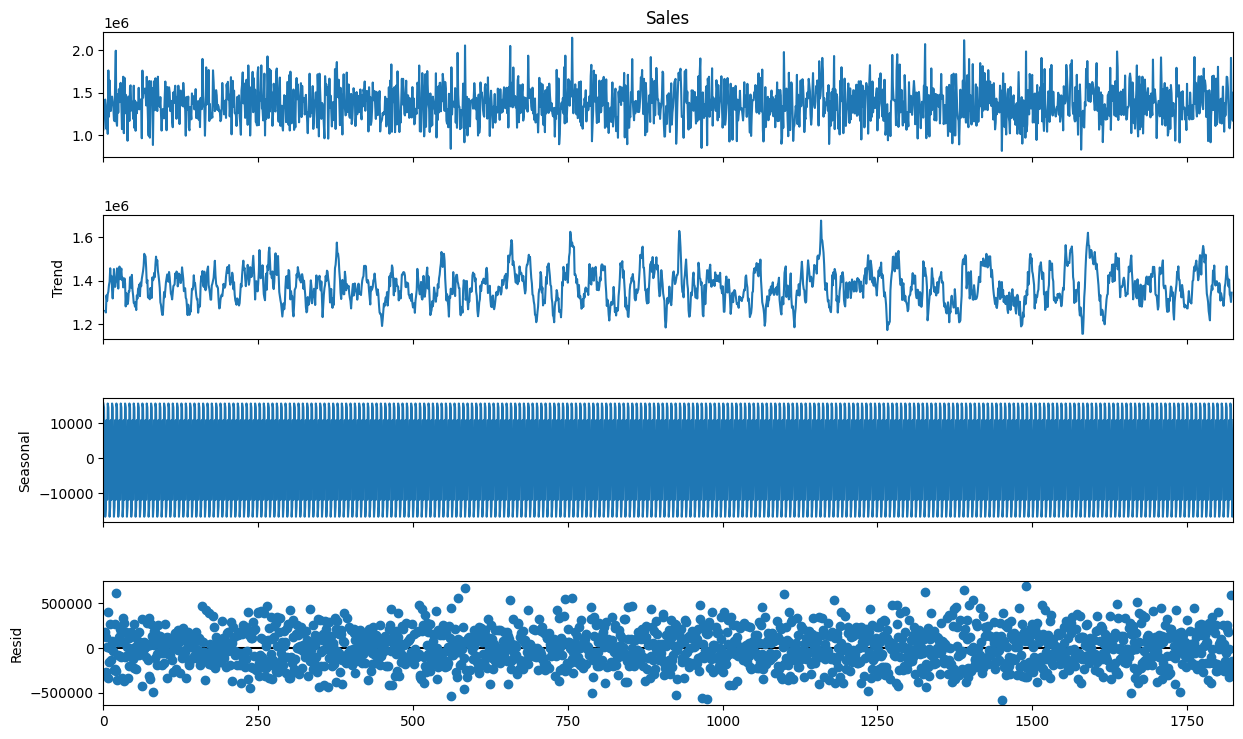

In [6]:
# 3. Analysis & Seasonal Decomposition
# ===========================
# Plot the overall sales trend
plt.figure(figsize=(18, 7))
plt.plot(daily_sales[DATE_COLUMN], daily_sales[SALES_COLUMN])
plt.title('Total Indian Store Sales (2019–2023)')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(daily_sales[SALES_COLUMN], model='additive', period=7)
print("\n--- Plotting Seasonal Decomposition ---")
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

In [7]:
# 4. Prophet Model Training & Forecasting
# ===========================
# Prepare data for Prophet
ts_df = daily_sales.rename(columns={DATE_COLUMN: 'ds', SALES_COLUMN: 'y'})

# Split data into training and testing sets
train = ts_df[:-90]
test = ts_df[-90:]
print(f"\nTraining data: {len(train)} days")
print(f"Test data: {len(test)} days")

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
print("\n--- Training Prophet Model ---")
model.fit(train)
print("Model training complete.")

# Create a future dataframe to forecast on
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)


Training data: 1736 days
Test data: 90 days

--- Training Prophet Model ---


18:33:00 - cmdstanpy - INFO - Chain [1] start processing
18:33:00 - cmdstanpy - INFO - Chain [1] done processing


Model training complete.


In [8]:
# 5. Model Evaluation
# ===========================
# Merge the test data with the forecast to compare
results_on_test = pd.merge(test, forecast, on='ds')
actuals = results_on_test['y']
predictions = results_on_test['yhat']

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(actuals, predictions) * 100
print(f"\n--- Model Performance on Test Set ---")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


--- Model Performance on Test Set ---
Mean Absolute Percentage Error (MAPE): 12.52%



--- Plotting Forecast vs. Actuals ---


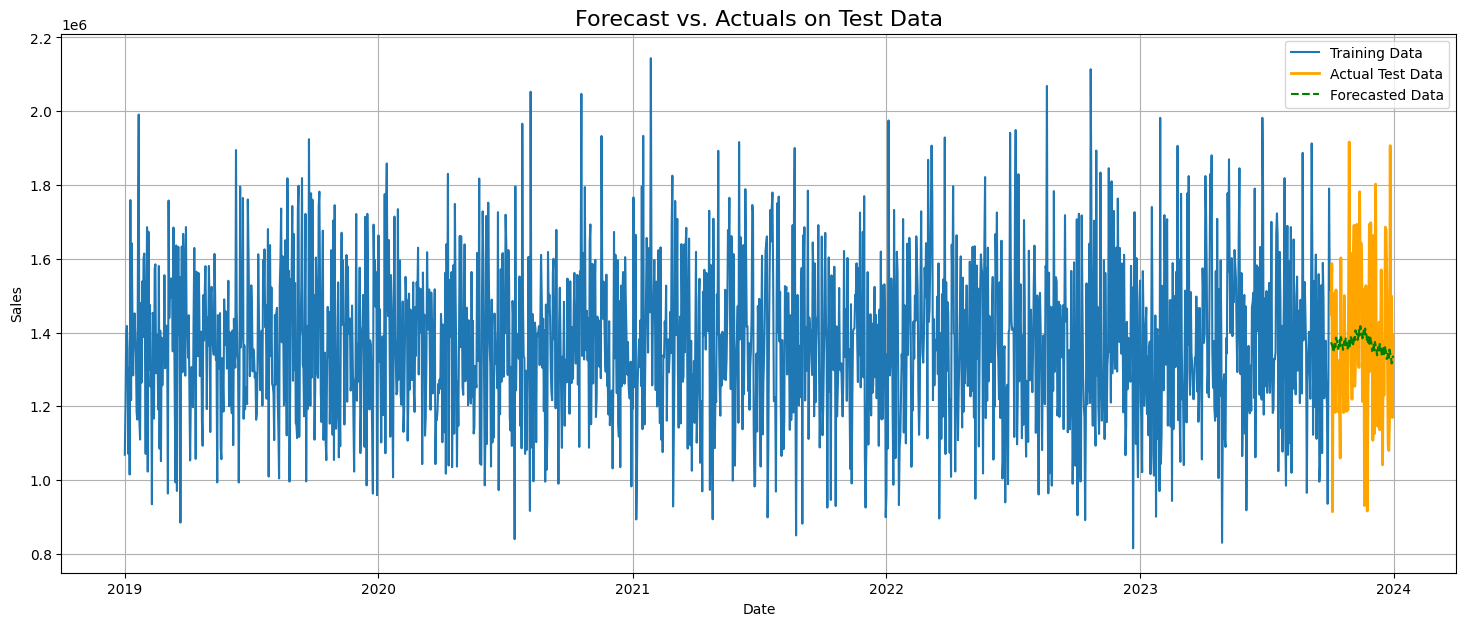

In [9]:
# 6. Visualize Forecast vs. Actuals
# ===========================
print("\n--- Plotting Forecast vs. Actuals ---")
plt.figure(figsize=(18, 7))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Actual Test Data', color='orange', linewidth=2)
plt.plot(test['ds'], predictions, label='Forecasted Data', color='green', linestyle='--')
plt.title('Forecast vs. Actuals on Test Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# 7. Export Results for Power BI
# ===========================
output_path = "../results/forecast_output.csv"
results_folder = "../results"

# Create the 'results' folder if it doesn't exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Merge the forecast with actuals for a complete dataset
results_df = pd.merge(ts_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='outer')

# Save the results to a CSV file
results_df.to_csv(output_path, index=False)

print("\n--- Export Complete ---")
print(f"Final forecast data has been saved to: {output_path}")


--- Export Complete ---
Final forecast data has been saved to: ../results/forecast_output.csv
